In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import scanpy as sc
import anndata
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
adata_rna = sc.read_h5ad('/hpc/mydata/siyu.he/coral_storage/Data_SpatialGlue/Dataset13_Simulation1/adata_RNA.h5ad')
adata_adt = sc.read_h5ad('/hpc/mydata/siyu.he/coral_storage/Data_SpatialGlue/Dataset13_Simulation1/adata_ADT.h5ad')

In [3]:
# Specify data type
data_type = '10x'

# Fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed = 2022
fix_seed(random_seed)


from SpatialGlue.preprocess import clr_normalize_each_cell, pca


# RNA
sc.pp.scale(adata_rna)
adata_rna.obsm['feat'] = pca(adata_rna, n_comps=adata_rna.n_vars-1)

# Protein
adata_adt = clr_normalize_each_cell(adata_adt)
sc.pp.scale(adata_adt)
adata_adt.obsm['feat'] = pca(adata_adt, n_comps=adata_adt.n_vars-1)

from SpatialGlue.preprocess import construct_neighbor_graph
data = construct_neighbor_graph(adata_rna, adata_adt, datatype=data_type)

# define model
from SpatialGlue.SpatialGlue_pyG import Train_SpatialGlue
model = Train_SpatialGlue(data, datatype=data_type, device='cuda')

# train model
output = model.train()

adata = adata_rna.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1'].copy()
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2'].copy()
adata.obsm['SpatialGlue'] = output['SpatialGlue'].copy()
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']

# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering

#adata_qz = sc.AnnData(X=new_data_qz)
#adata_qz.obsm['spatial'] = new_coords

# Preprocess the data (e.g., normalization, PCA)
#sc.pp.normalize_total(adata_qz)


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/SpatialGlue/preprocess.py:132: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  return torch.sparse.FloatTensor(indices, values, shape)
  0%|          | 0/200 [00:00<?, ?it/s]/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/SpatialGlue/model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████| 200/200 [00:03<00:00, 61.42it/s]


Model training finished!



In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def cluster_latent_rep(latent_rep, n_clusters=5):
    scaler = StandardScaler()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(latent_rep)
    return clusters
clusters = cluster_latent_rep(adata.obsm['SpatialGlue'], n_clusters=5)
adata.obs['cluster'] =clusters
adata.obs['cluster'] = adata.obs['cluster'].astype('category')


In [5]:
plt.rcParams['figure.figsize'] = (2.5,2.5)
plt.rcParams['font.size'] = 15
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['figure.dpi'] = 800

TOTALVI_CLUSTERS_KEY = "leiden_totalVI"

#sc.pp.neighbors(rna, use_rep=TOTALVI_LATENT_KEY)
#sc.tl.umap(rna)
#sc.tl.leiden(rna, key_added=TOTALVI_CLUSTERS_KEY)

#sc.pp.scale(adata)
sc.pp.neighbors(adata, use_rep='SpatialGlue')
sc.tl.leiden(adata, resolution=0.02)


/tmp/ipykernel_3680944/1661170868.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.02)


In [6]:
custom_palette = ['#f4f1de',  '#81b29a', '#f2cc8f', '#3d405b','#e07a5f',]
annotation_mapping = {
    '0': 'factor1',
    '1': 'factor2',
    '2': 'factor3',
    '3': 'factor4',
    '4': 'backgr'  
}

adata.obs['leiden'] = adata.obs['leiden'].map(annotation_mapping)


Text(0, 0.5, '')

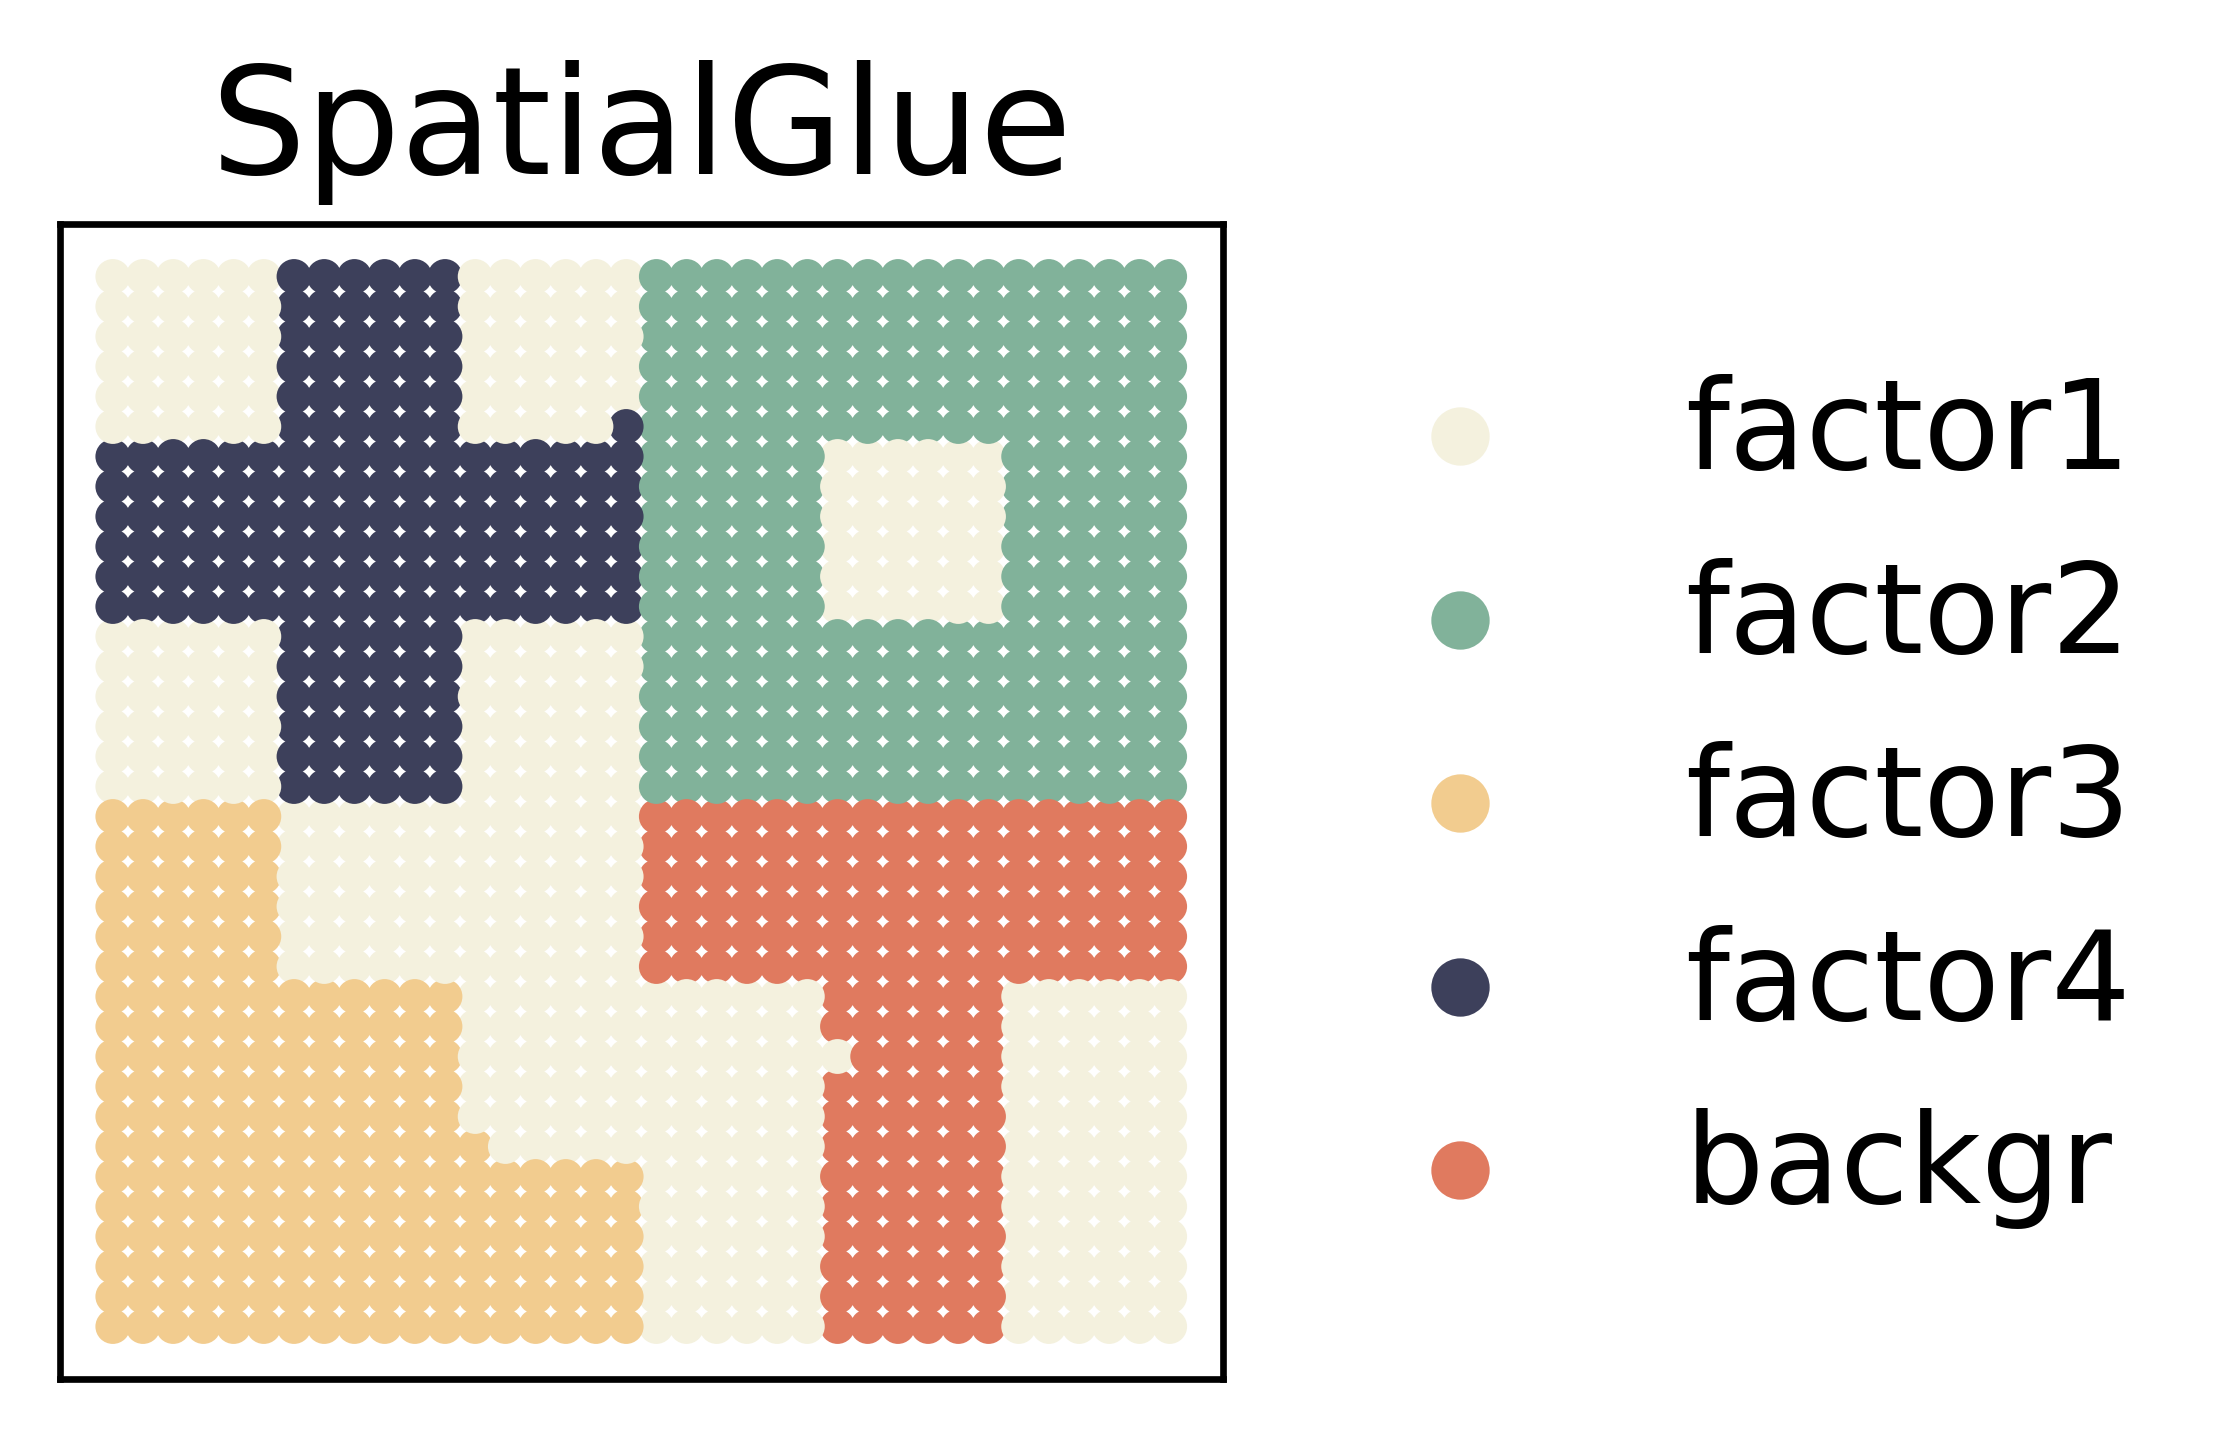

In [7]:
plt.rcParams['figure.figsize'] = (2.5,2.5)
plt.rcParams['font.size'] = 15
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['figure.dpi'] = 600

sc.pl.embedding(adata, basis='spatial', color='leiden', 
                title='SpatialGlue', s=70, show=False,palette=custom_palette)
plt.xlabel('')
plt.ylabel('')


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0, 0.5, '')

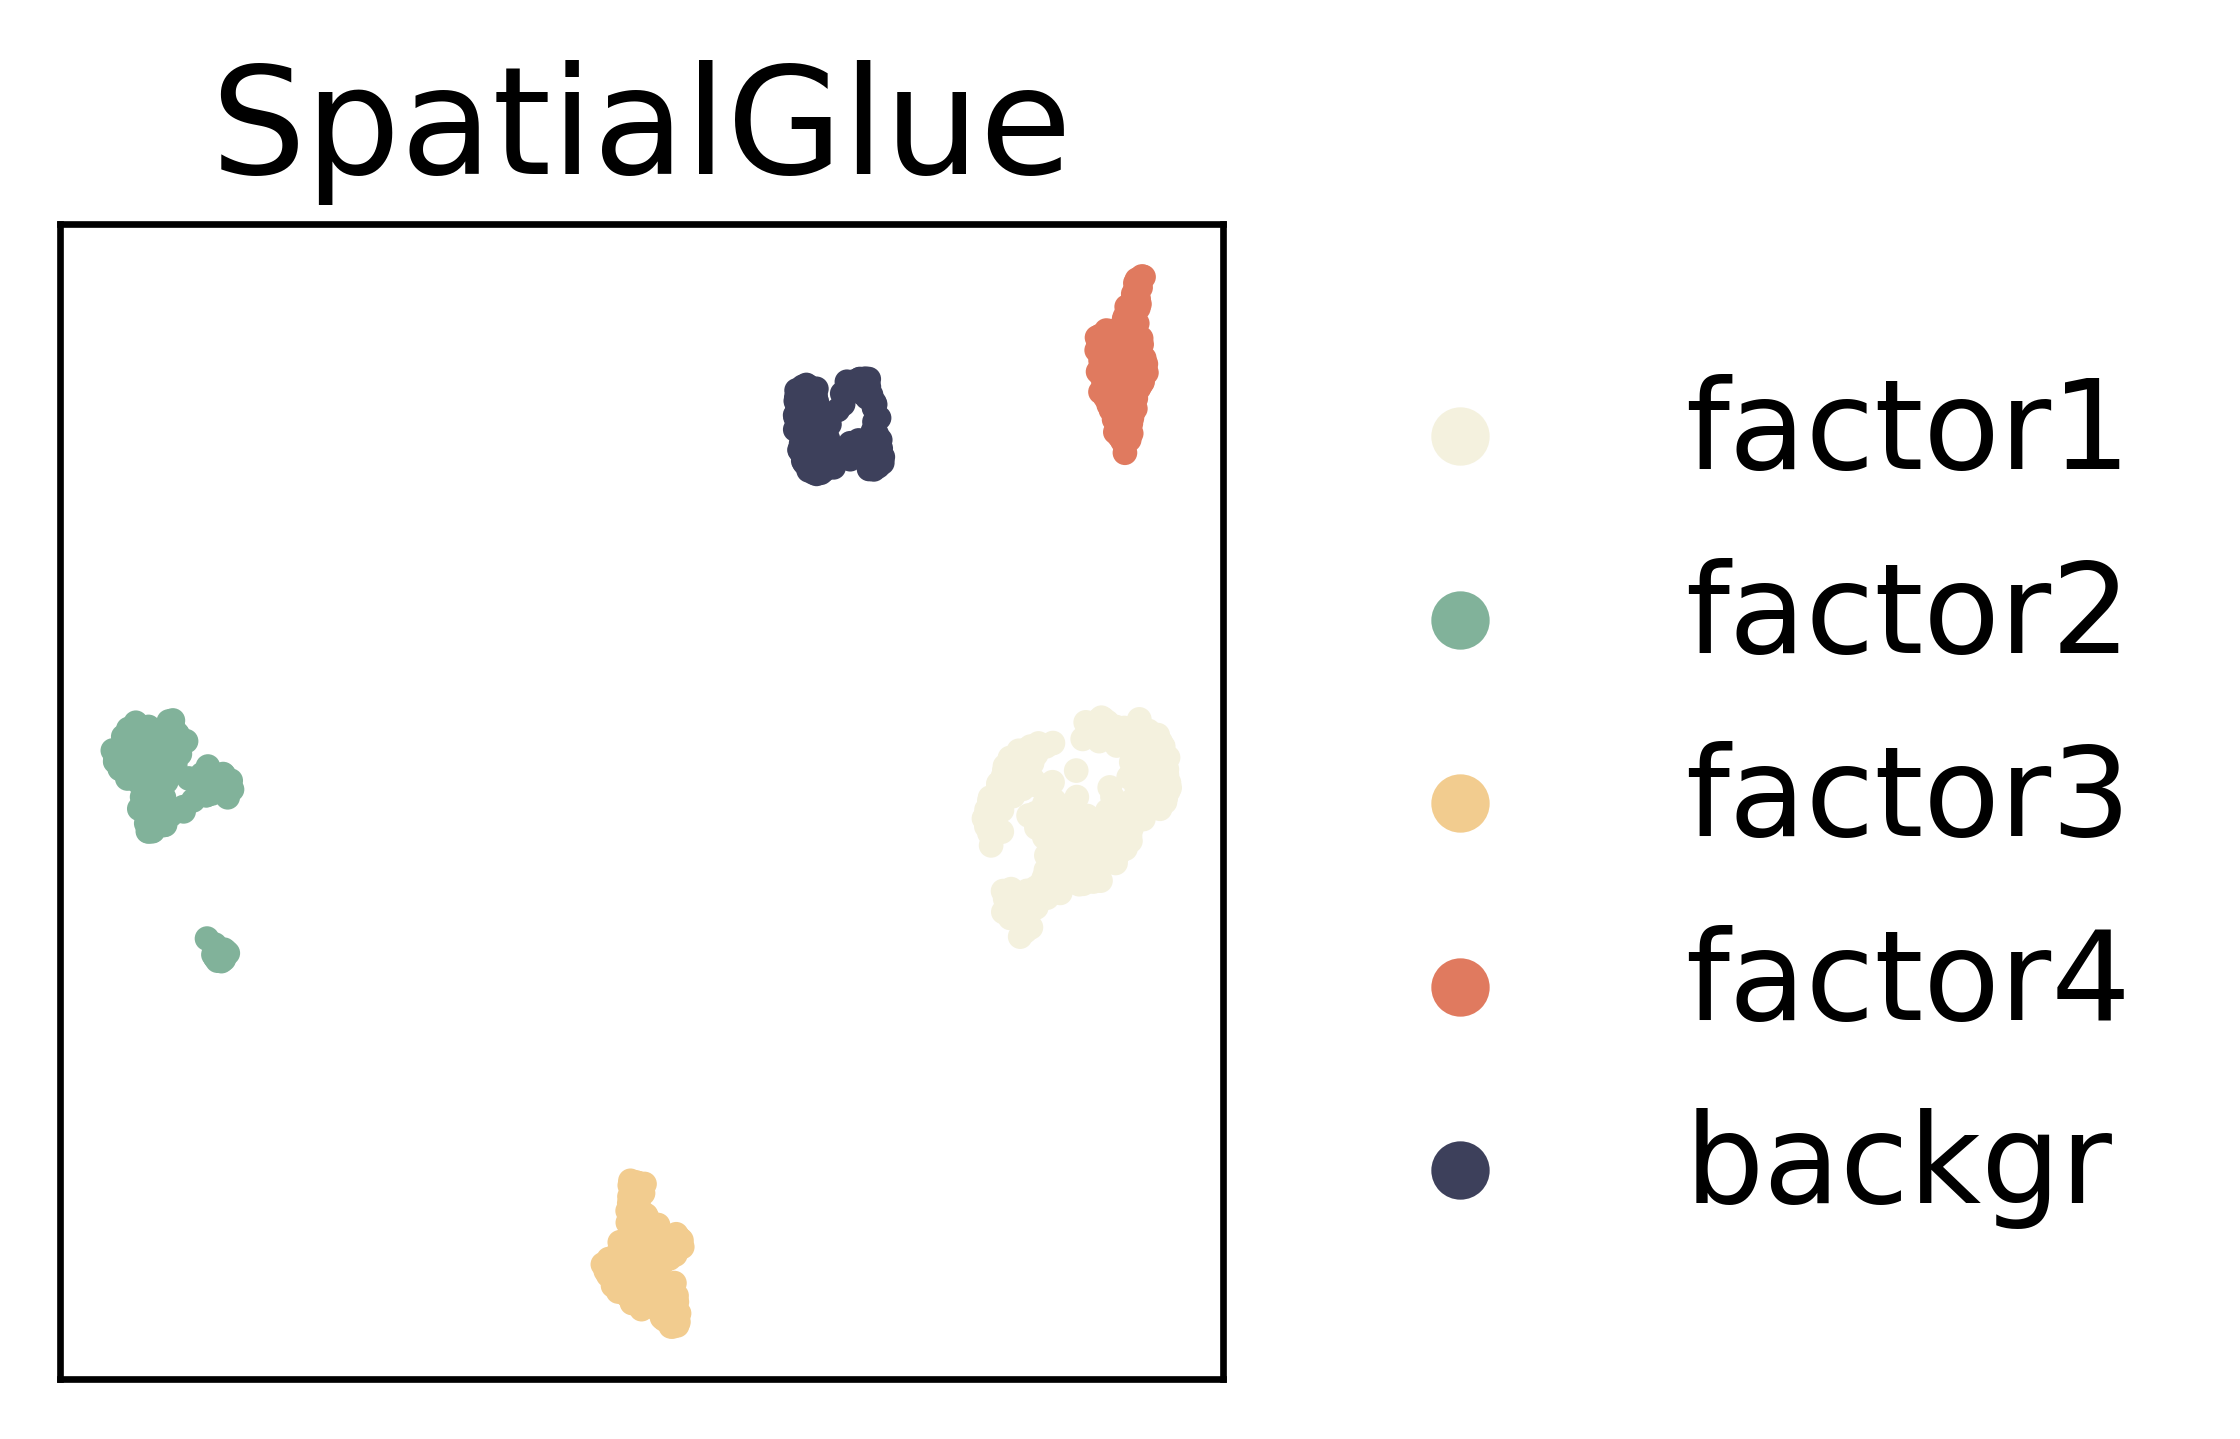

In [10]:
from umap import UMAP
umap_model = UMAP(n_neighbors=30, min_dist=0.2, n_components=2, random_state=42)

# Fit the model to your data and transform it
z_umap = umap_model.fit_transform(adata.obsm['SpatialGlue'])
adata.obsm['umap'] = z_umap 

custom_palette = ['#f4f1de',  '#81b29a', '#f2cc8f', '#e07a5f','#3d405b',]

sc.pl.embedding(adata, basis='umap', title='SpatialGlue', color='leiden', s=35, show=False, palette=custom_palette)
plt.xlabel('')
plt.ylabel('')


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0, 0.5, '')

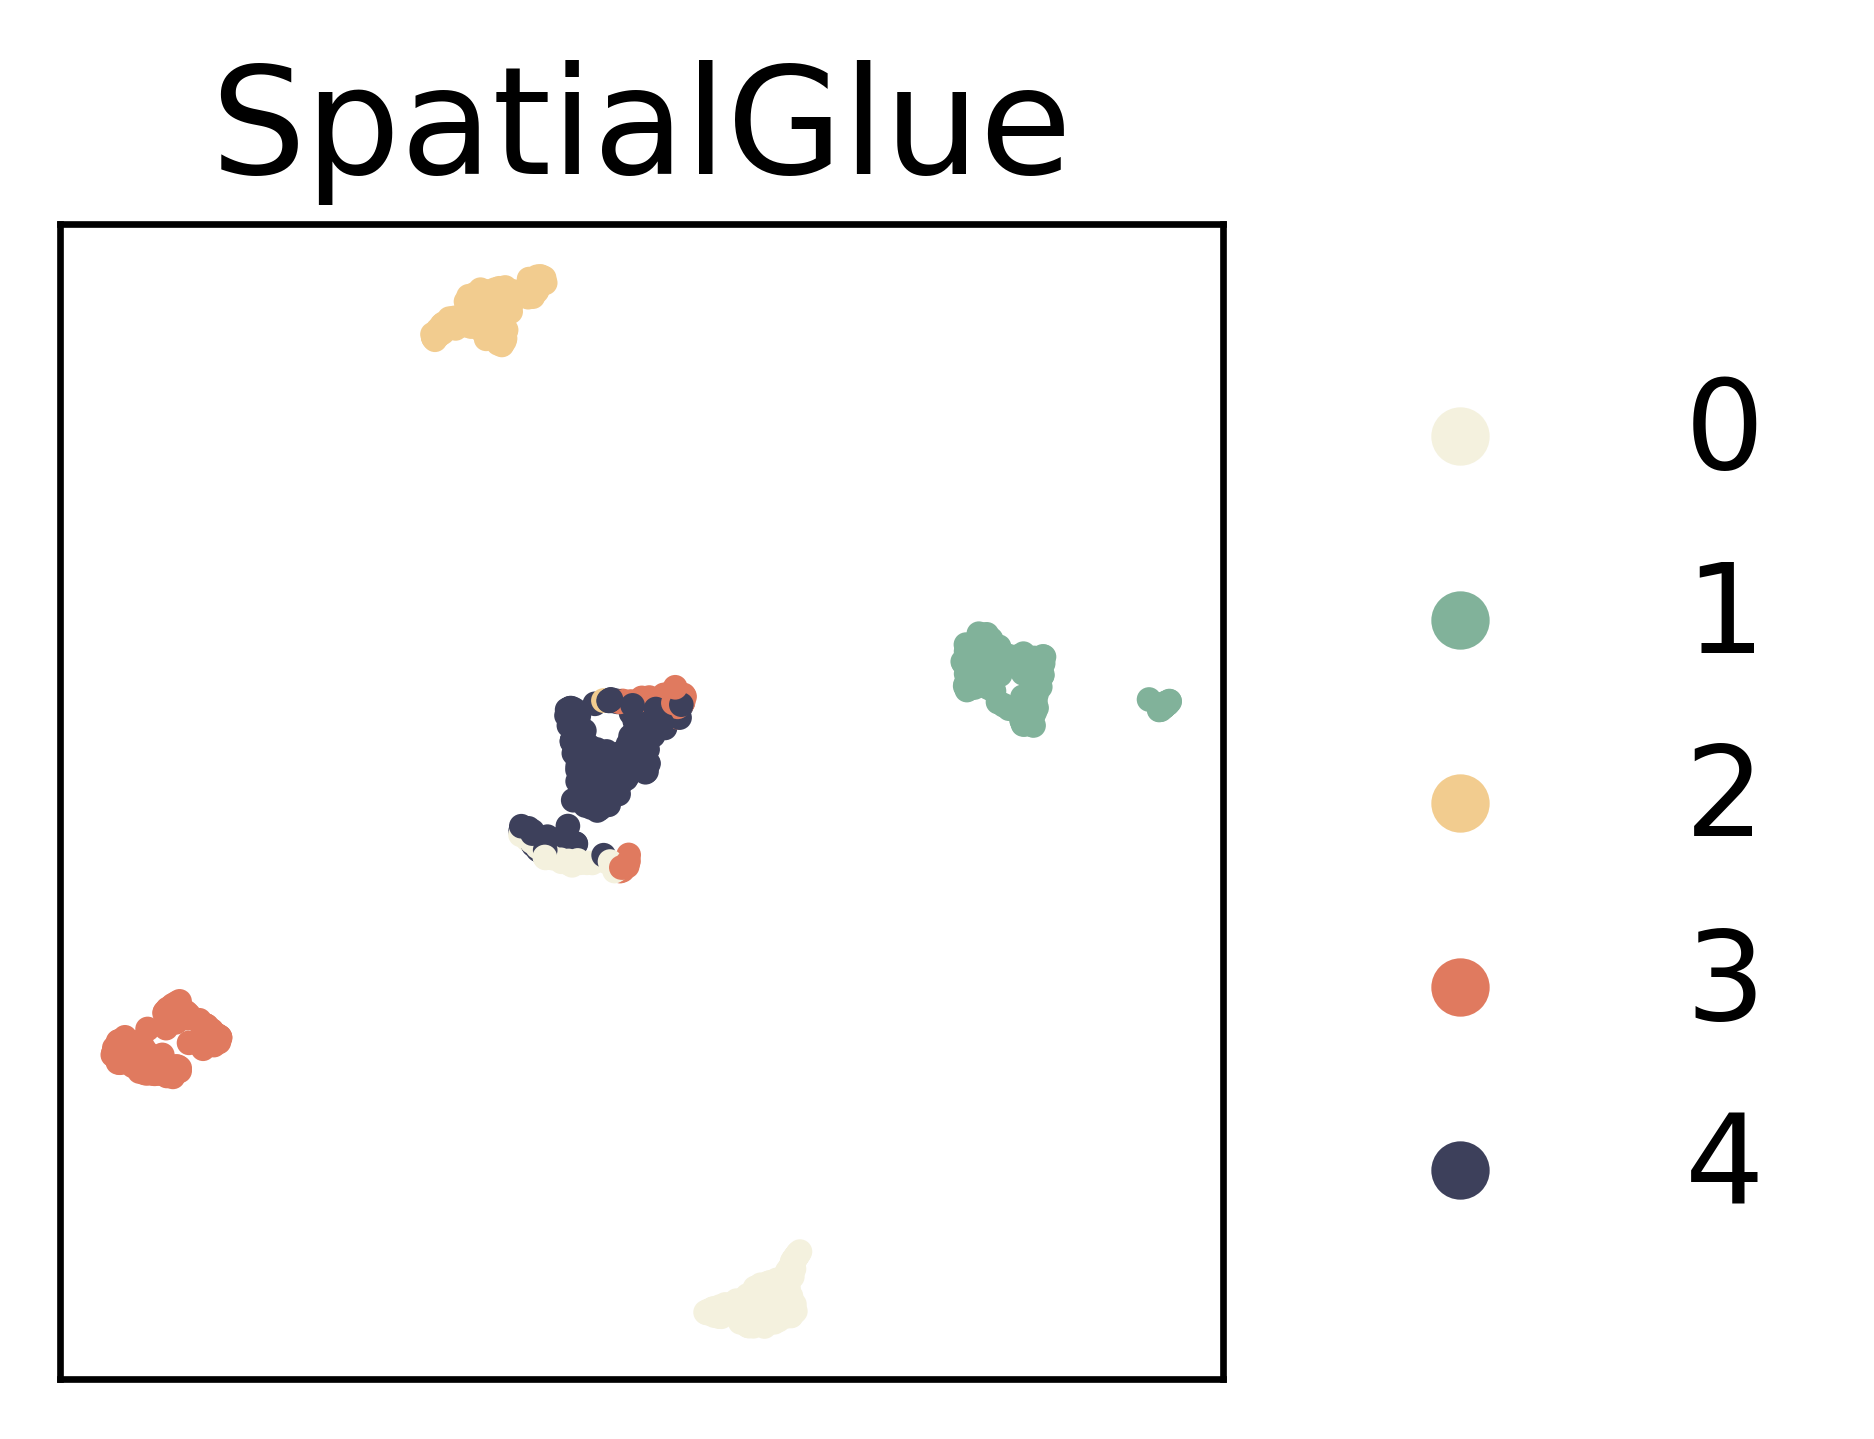

In [8]:
from umap import UMAP
umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit the model to your data and transform it
z_umap = umap_model.fit_transform(adata.obsm['SpatialGlue'])
adata.obsm['umap'] = z_umap 

custom_palette = ['#f4f1de',  '#81b29a', '#f2cc8f', '#e07a5f','#3d405b',]

sc.pl.embedding(adata, basis='umap', title='SpatialGlue', color='cluster', s=35, show=False, palette=custom_palette)
plt.xlabel('')
plt.ylabel('')


<Axes: title={'center': 'SpatialGlue'}, xlabel='spatial1', ylabel='spatial2'>

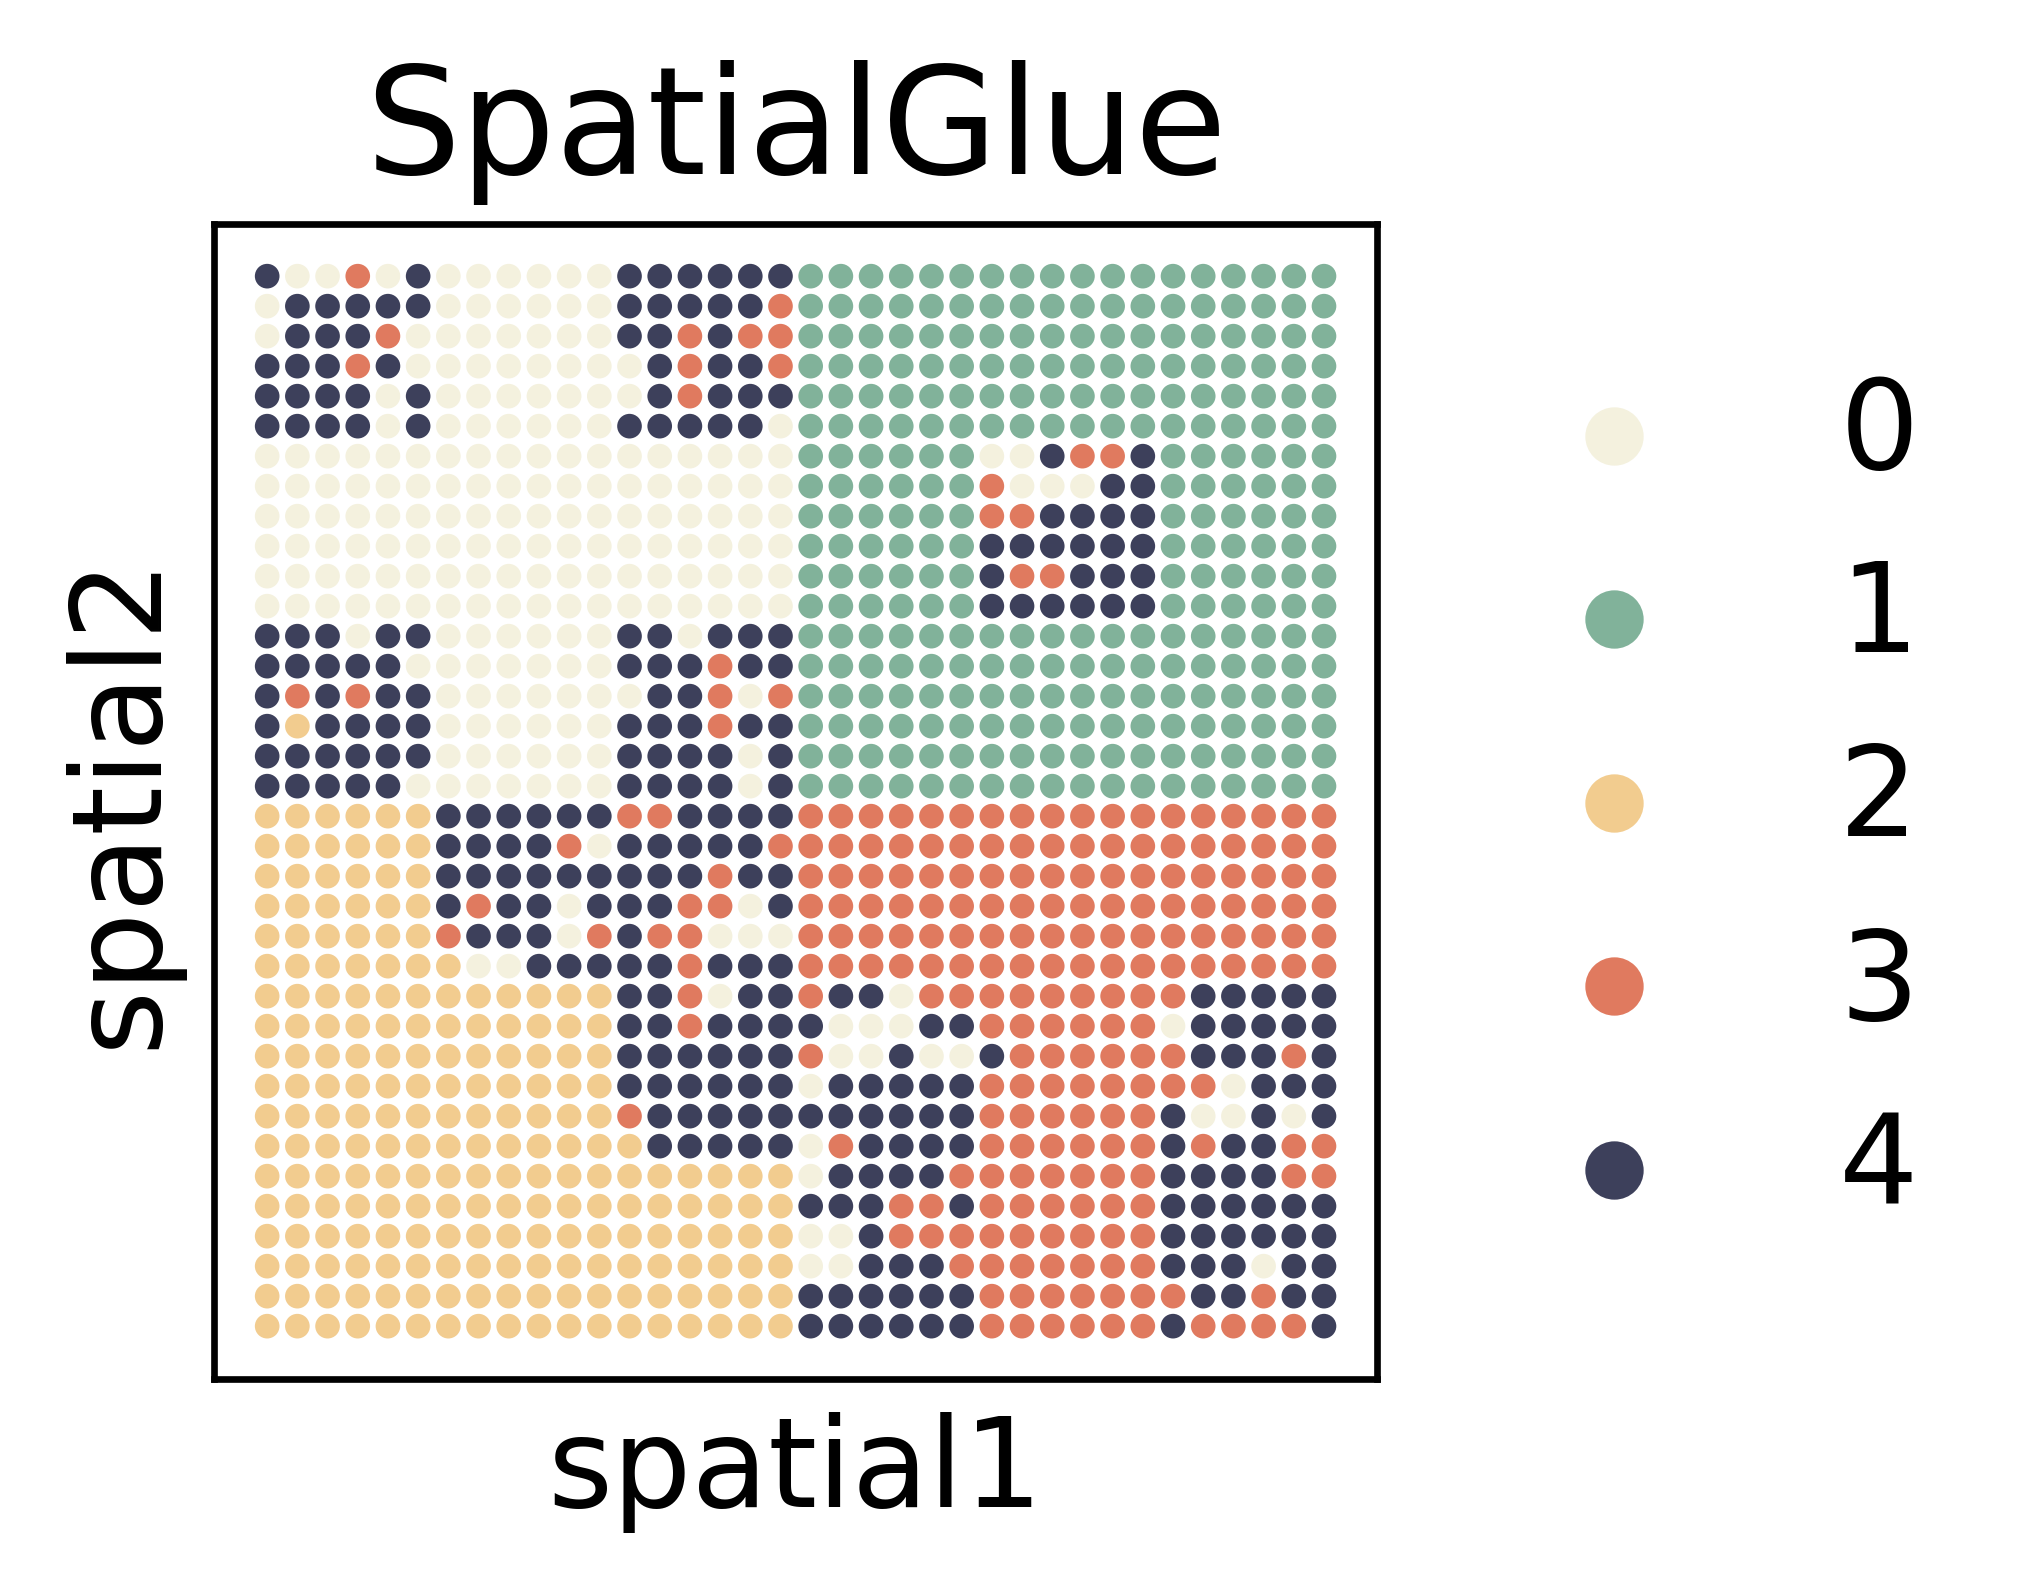

In [9]:
sc.pl.embedding(adata, basis='spatial', color='cluster', 
                title='SpatialGlue', s=35, show=False)

In [20]:
adata.write('/hpc/mydata/siyu.he/coral_storage/coral_results/simulation/spatialglue_simu1.h5ad')